# Multivariate Time Series Analysis and Forecasting With Gradiant Boosting

# Project Description
#### 1. goal
This project aimed to compare various predictive tools on a large time series dataset and predict the future values. Due to this project’s nature, the solution needed to be scalable and fast in addition to accurate.
#### 2. data
The dataset is from Kaggle and consists of 34 months worth of data for 214,000 items across 42 stores. The dataset includes the number of units sold and the price for that item.
One of the main challenges of working with this dataset was its limited past data, making it hard to learn trends and seasonality.
The other challenge was its data preparation step, as each model needed its input.
#### 3. EDA and Visualisation
After preprocessing the data, to get a sense of how it looked, I used statistical tests to check for trends and seasonality in the data and plotted graphs to visualize it.
#### 4. Modeling and Prediction
I used three different models for predicting the future values.
##### 4.1. Facebook Prophet
Besides compatibility issues and that I had to downgrade a series of packages to use fbprophet, the main problem with fbprophet was its speed. So, of course, in many circumstances, the package would have its merits, but I had to use other tools. The codes for fbprophet are available in another notebook.
##### 4.2. Gradient Boosting
The second method that I used was XGBoost. To do so, I had to flatten data and reshape each 2D time series matrix into a 1D row. After that, I tried two hypotheses, whether to fit data using all the prior time blocks or to use a more limited horizon to replicate the seasonality and the trends. (i.e., I wanted to see whether it would help to have all the seasons with the same number of repetitions.)
The result was that the model did better with more data from the past.
##### 4.3. SARIMAX
The third method which showed the lowest error was SARIMAX. Seasonal Autoregressive Integrated Moving Average with Exogenous
variables Regressions. However, finding the optimum parameters for fitting was not as fast as one would hope it would be.
##### 4.4 Final model
The main predictive method was SARIMAX and on occasions when the data could not be fitted using the pmdarima package, I used XGBoost, and for the rows that there were not any sales before the target month, I set the prediction to be zero.

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

C:\Users\axb190032\Desktop\Python-Virtual-Enviroment\Enviroment1\Scripts\python.exe
3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=5, releaselevel='final', serial=0)


pmdarima version

pip: 21.0.1
setuptools: 49.2.1
sklearn: 0.24.1
statsmodels: 0.12.2
numpy: 1.19.4
scipy: 1.6.2
Cython: 0.29.23
pandas: 1.2.4
joblib: 1.0.1
pmdarima: 1.8.2rc3

In [9]:
import numpy as np
import pandas as pd

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels

import warnings
warnings.filterwarnings('ignore')

import dill
import pickle

import sys

sys.version_info

sys.version_info(major=3, minor=10, micro=5, releaselevel='final', serial=0)

# 1- Importing The Data

In [10]:
items = pd.read_csv('./items.csv')
shops = pd.read_csv('./shops.csv')
cats = pd.read_csv('./item_categories.csv')
train = pd.read_csv('./sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('./test.csv').set_index('ID')
sample = pd.read_csv('./sample_submission.csv')
#data1 = pd.read_csv('./data1.csv')

# 2- Data Cleaning and Conversion

In [11]:
train['date'] = train['date'].str.replace('.','-')
train['date'] = pd.to_datetime(train['date'], format='%d-%m-%Y', errors='coerce')

In [12]:
train = train[train.item_price < 100000]
train = train[train.item_cnt_day < 1001]
median = train[(train.shop_id == 32) & (train.item_id == 2973) & (train.date_block_num == 4) & (
            train.item_price > 0)].item_price.median()
train.loc[train.item_price < 0, 'item_price'] = median

# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id', 'city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id', 'type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)


# 3- Creating a data matrix

we are going to make an empty dataframe which will include all the possible combinations of items sold and their monthblock. Then we are going to add the aggregated sales and price data.

In [13]:
# aggregate on item level
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i],set(test.shop_id.unique()),set(test.item_id.unique()))), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
#matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [14]:
matrix.shape , train.shape

((7282800, 3), (2935847, 6))

After creating the initial matrix, we add aggregated data from our train dataset.

first we average price per month

In [64]:
monthly_price = train.groupby(['shop_id','item_id', 'date_block_num' , pd.Grouper(key="date",freq='M')])['item_price'].mean().reset_index()

first we average price per month for each item at each shop.

In [65]:
data = matrix.merge(monthly_price.drop(['date'],axis=1),
                    how= 'left',
                    on= ['date_block_num','shop_id' , 'item_id']
                    )

In [66]:
data

,date_block_num,shop_id,item_id,item_price
0,0,2,30,NaN
1,0,2,31,NaN
2,0,2,32,NaN
3,0,2,33,499.0
4,0,2,38,NaN
...,...,...,...,...
7282795,33,59,22162,NaN
7282796,33,59,22163,NaN
7282797,33,59,22164,NaN
7282798,33,59,22166,NaN


Now we sum the monthly sale for each month for each product at each store to aggregate the data

In [34]:
monthly_sale = train.groupby(['shop_id' ,'item_id', 'date_block_num' , pd.Grouper(key="date",freq='M')])['item_cnt_day'].agg(sum).reset_index()

In [35]:
date_month = [*monthly_sale['date'].unique()]
#date_month = date_month.sort()
date_month = np.sort(date_month, axis=0)
date_month = pd.Series(date_month)

In [69]:
for i in range(len(date_month)):
    date_month[i] = date_month[i].replace(day = 1)

In [70]:
data = data.merge(monthly_sale.drop(['date'],axis=1),
                    how = 'left' ,
                    on = ['date_block_num','shop_id','item_id'] )

In [71]:
data = data.sort_values(['shop_id' , 'item_id','date_block_num']).reset_index().drop(['index'],axis=1)

In [72]:
data = data.rename(columns = {'item_cnt_day' : 'item_cnt_month'})

In [73]:
data.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,0,2,30,NaN,NaN
1,1,2,30,NaN,NaN
2,2,2,30,359.0,1.0
3,3,2,30,NaN,NaN
4,4,2,30,NaN,NaN


In [74]:
data.to_csv('./data.csv', index= False)

In [22]:
data = pd.read_csv('./data.csv')

keeping the unique set of items and shops

In [23]:
shop_list = [*set(data.shop_id)]
item_list = [*set(data.item_id)]

# 4- Missing Data

we have two data columns with missing data, price and sales count.
After inspecting the data, I belive missing data is the result of lack of sale for a particular item in a particular month.
Since the dataset is very big and price generally foloolws a steay trend I will use simple methods to impute missing prices. If we have the value for past and future of a certain point, we interpolate the missing data in between and for the future and past we use forward fill and backward fill.

In [78]:
data['item_cnt_month'] = data['item_cnt_month'].fillna(0)

In [79]:
%%time
interpolate = []
for j in shop_list:
    temp = data[(data["shop_id"] == j)].copy()
    for i in item_list:
        interpolate.append(temp[temp['item_id']==i]['item_price'].interpolate(method='linear').fillna(method='bfill').fillna(method="ffill").copy())

# the interpolate method forward fills missing values if there is no future value

CPU times: total: 2min 43s
Wall time: 2min 43s


In [80]:
# we need to convert the list of series to a single list of values
import itertools
interpolate_series = list(itertools.chain.from_iterable(interpolate))

In [81]:
# we check for the length of the list to see if it is the same as the original dataframe
len(interpolate_series) == data.shape[0], len(interpolate_series), data.shape[0]

(True, 7282800, 7282800)

In [82]:
# dill.dump(interpolate_series, open('interpolate_series.pkl', 'wb'))
# interpolate = dill.load(open('./interpolate.pkl', 'rb'))

In [83]:
data['item_price'] = interpolate_series

In [84]:
data.to_csv('./data.csv', index= False)

# 5- Feature Engineering

adding the length of each month

In [85]:
m_len = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31,
                   31,28,31,30,31,30,31,31,30,31,30,31,
                   31,28,31,30,31,30,31,31,30,31])
len(m_len)

34

In [86]:
data['num_days_in_month'] = data['date_block_num'].map(m_len).astype(np.int8)

,date_block_num,shop_id,item_id,item_price,item_cnt_month,num_days_in_month
0,0,2,30,359.000000,0.0,31
1,1,2,30,359.000000,0.0,28
2,2,2,30,359.000000,1.0,31
3,3,2,30,372.333333,0.0,30
4,4,2,30,385.666667,0.0,31


adding month and year as dummy variables

In [87]:
data['month'] = data['date_block_num']%12+1
data['year'] = (data['date_block_num']//12)

,date_block_num,shop_id,item_id,item_price,item_cnt_month,num_days_in_month,month,year
0,0,2,30,359.000000,0.0,31,1,0
1,1,2,30,359.000000,0.0,28,2,0
2,2,2,30,359.000000,1.0,31,3,0
3,3,2,30,372.333333,0.0,30,4,0
4,4,2,30,385.666667,0.0,31,5,0
...,...,...,...,...,...,...,...,...
7282795,29,59,22167,299.000000,0.0,30,6,2
7282796,30,59,22167,299.000000,0.0,31,7,2
7282797,31,59,22167,299.000000,0.0,31,8,2
7282798,32,59,22167,299.000000,0.0,30,9,2


adding revenue per month as a feature

In [88]:
data['revenue'] = data['item_price'] *  data['item_cnt_month']

,date_block_num,shop_id,item_id,item_price,item_cnt_month,num_days_in_month,month,year,revenue
0,0,2,30,359.000000,0.0,31,1,0,0.0
1,1,2,30,359.000000,0.0,28,2,0,0.0
2,2,2,30,359.000000,1.0,31,3,0,359.0
3,3,2,30,372.333333,0.0,30,4,0,0.0
4,4,2,30,385.666667,0.0,31,5,0,0.0
...,...,...,...,...,...,...,...,...,...
7282795,29,59,22167,299.000000,0.0,30,6,2,0.0
7282796,30,59,22167,299.000000,0.0,31,7,2,0.0
7282797,31,59,22167,299.000000,0.0,31,8,2,0.0
7282798,32,59,22167,299.000000,0.0,30,9,2,0.0


adding date as a feature

In [89]:
data['date'] = data['date_block_num'].map(date_month)

In [98]:
data.to_csv('./data.csv', index= False)

The company requires us to predict sales for particular stores and items, we are going to merge oor main data with the test set to narrow our predictions.

In [90]:
df = test.sort_values(['shop_id','item_id']).reset_index().merge(data, how='left', on=['shop_id','item_id'])
df

,ID,shop_id,item_id,date_block_num,item_price,item_cnt_month,num_days_in_month,month,year,revenue,date
0,22987,2,30,0,359.000000,0.0,31,1,0,0.0,2013-01-01
1,22987,2,30,1,359.000000,0.0,28,2,0,0.0,2013-02-01
2,22987,2,30,2,359.000000,1.0,31,3,0,359.0,2013-03-01
3,22987,2,30,3,372.333333,0.0,30,4,0,0.0,2013-04-01
4,22987,2,30,4,385.666667,0.0,31,5,0,0.0,2013-05-01
...,...,...,...,...,...,...,...,...,...,...,...
7282795,148377,59,22167,29,299.000000,0.0,30,6,2,0.0,2015-06-01
7282796,148377,59,22167,30,299.000000,0.0,31,7,2,0.0,2015-07-01
7282797,148377,59,22167,31,299.000000,0.0,31,8,2,0.0,2015-08-01
7282798,148377,59,22167,32,299.000000,0.0,30,9,2,0.0,2015-09-01


In [ ]:
#df.to_csv('./df.csv', index= False)

In [15]:
df = pd.read_csv('./df.csv')

In [ ]:
df.head()

# 5- Visualisation

to get a rough idea of how the data looks like, we are going to plot its monthly averages.
There is a clear seasonality and an upward trend both for sales count and total revenue.

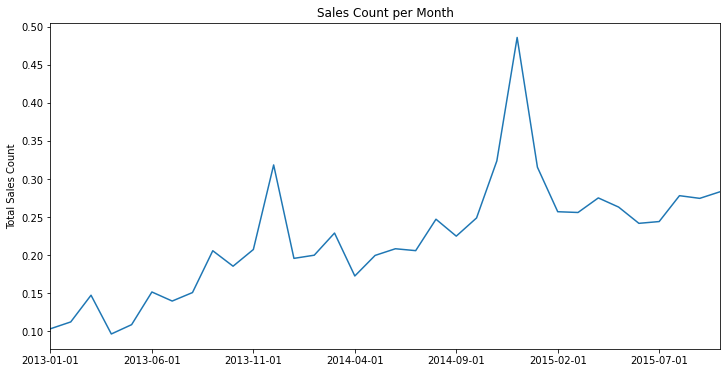

In [16]:
ax = df.groupby(['date'])['item_cnt_month'].mean().plot(kind='line',figsize=(12,6))
ax.autoscale(axis='x',tight=True); ax.set(xlabel=''); ax.set(ylabel='Total Sales Count'), ax.set(title='Sales Count per Month');

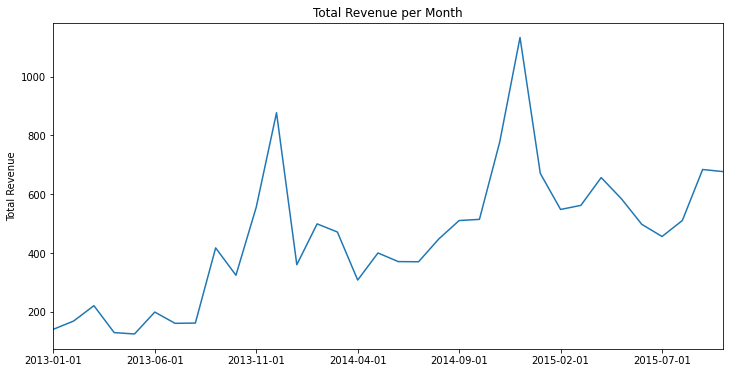

In [17]:
ax = df.groupby(['date'])['revenue'].mean().plot(kind='line',figsize=(12,6))
ax.autoscale(axis='x',tight=True); ax.set(xlabel=''); ax.set(ylabel='Total Revenue'), ax.set_title('Total Revenue per Month');

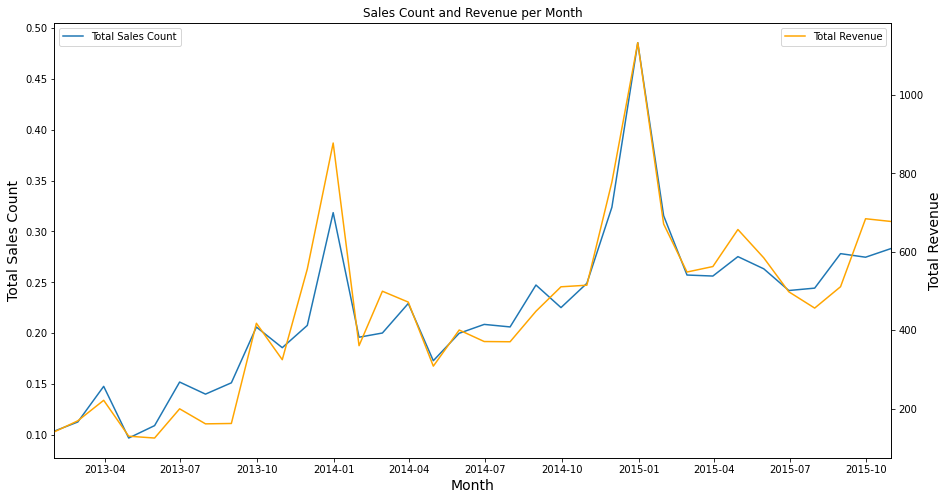

In [37]:
# creating subplots()
fig,ax = plt.subplots(figsize=(15,8))
# plot 1
x = date_month
total_sales_count = df.groupby(['date'])['item_cnt_month'].mean()
ax.plot(x, total_sales_count,label="Total Sales Count")
# axis labels
ax.set_xlabel("Month", fontsize = 14)
ax.set_ylabel("Total Sales Count", fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
total_revenue = df.groupby(['date'])['revenue'].mean()
# make a plot with different y-axis using second axis object
ax2.plot(x, total_revenue,color="Orange",label="Total Revenue")
ax2.set_ylabel("Total Revenue",fontsize=14)
ax.autoscale(axis='x',tight=True); ax2.autoscale(axis='x',tight=True);
ax.legend(loc='upper left'),ax2.legend()
ax.set(title='Sales Count and Revenue per Month');

here we can see that the sales count and revenue are highly correlated, so we later are going to chack if using revenue can improve our predictions.

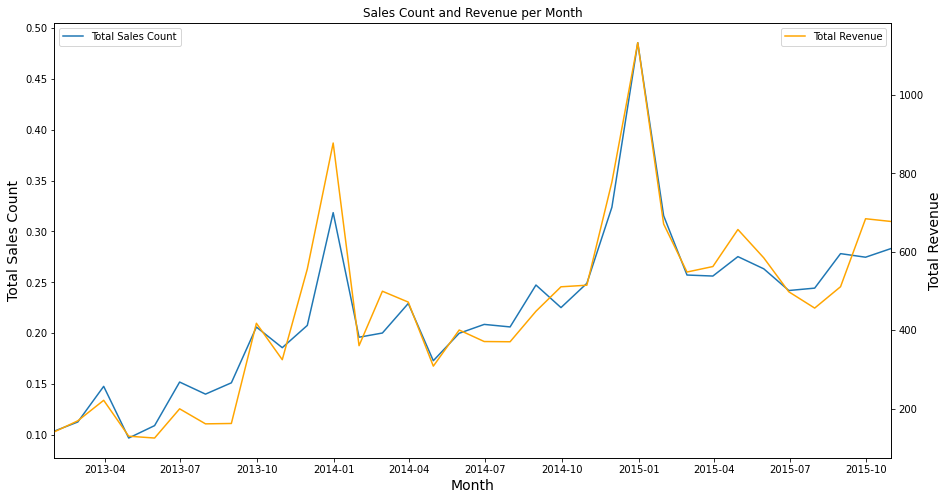

In [36]:
# creating subplots()
fig,ax = plt.subplots(figsize=(15,8))
# plot 1
x = date_month
total_sales_count = df.groupby(['date'])['item_cnt_month'].mean()
ax.plot(x, total_sales_count,label="Total Sales Count")
# axis labels
ax.set_xlabel("Month", fontsize = 14)
ax.set_ylabel("Total Sales Count", fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
total_revenue = df.groupby(['date'])['revenue'].mean()
# make a plot with different y-axis using second axis object
ax2.plot(x, total_revenue,color="Orange",label="Total Revenue")
ax2.set_ylabel("Total Revenue",fontsize=14)
ax.autoscale(axis='x',tight=True); ax2.autoscale(axis='x',tight=True);
ax.legend(loc='upper left'),ax2.legend()
ax.set(title='Sales Count and Revenue per Month');

here we check if sales count and revenue for a set of shops and we see that comparteively the ploted lines are more volatile.

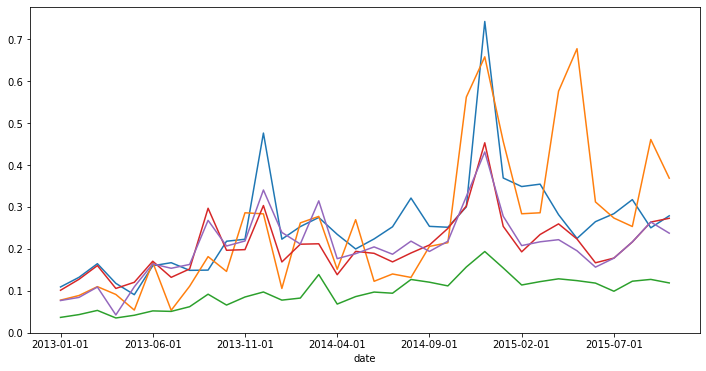

In [26]:
import random
random.seed(42)
rand_index = random.sample(shop_list, 5)
for i in rand_index:
    df[df['shop_id']==i].groupby(['date'])['item_cnt_month'].mean().rename(i).plot(kind='line',figsize=(12,6));

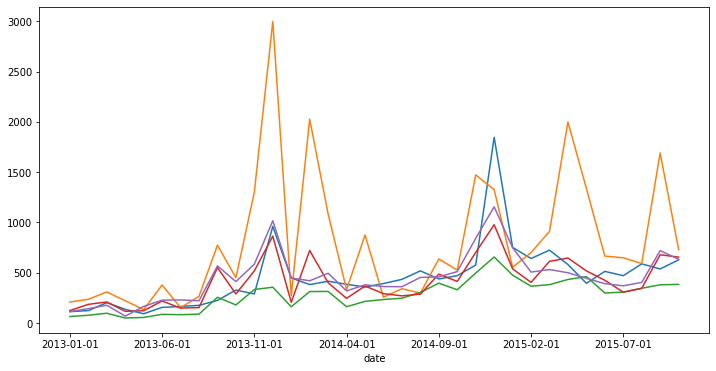

In [27]:
for i in rand_index:
    df[df['shop_id']==i].groupby(['date'])['revenue'].mean().rename(i).plot(kind='line',figsize=(12,6));

we are going to add these averages as potential exogenous predictor to our data set.

In [28]:
df.head()

,ID,shop_id,item_id,date_block_num,item_price,item_cnt_month,num_days_in_month,month,year,revenue,date,tot_cnt,tot_rev,tot_cnt_by_itm,tot_itm_by_shop,tot_rev_by_itm,tot_rev_by_shop
0,22987,2,30,0,359.000000,0.0,31,1,0,0.0,2013-01-01,0.103492,140.614816,0.000000,0.048627,0.000000,113.851484
1,22987,2,30,1,359.000000,0.0,28,2,0,0.0,2013-02-01,0.112470,168.683851,15.238095,0.026471,6707.465762,81.497120
2,22987,2,30,2,359.000000,1.0,31,3,0,359.0,2013-03-01,0.147521,220.938295,9.380952,0.046471,4236.825000,123.823106
3,22987,2,30,3,372.333333,0.0,30,4,0,0.0,2013-04-01,0.096657,129.369977,2.500000,0.032941,1130.126536,85.339833
4,22987,2,30,4,385.666667,0.0,31,5,0,0.0,2013-05-01,0.108880,124.717622,1.071429,0.031176,478.027027,73.187402


first we add the monthly total sales count average.

In [29]:
df = df.merge(df.groupby(['date'])['item_cnt_month'].mean().rename('tot_cnt').reset_index(), how='left', on='date')

monthly total revenue average.

In [30]:
df = df.merge(df.groupby(['date'])['revenue'].mean().rename('tot_rev').reset_index(), how='left', on='date')

monthly total sales by item average.

In [31]:
df = df.merge(df.groupby(['date','item_id'])['item_cnt_month'].mean().rename('tot_cnt_by_itm').reset_index(), how='left', on=['date','item_id'])

monthly total sales by shop average.

In [ ]:
df = df.merge(df.groupby(['date','shop_id'])['item_cnt_month'].mean().rename('tot_itm_by_shop').reset_index(), how='left', on=['date','shop_id'])

monthly revenue by item average.

In [ ]:
df = df.merge(df.groupby(['date','item_id'])['revenue'].mean().rename('tot_rev_by_itm').reset_index(), how='left', on=['date','item_id'])

monthly revenue by shop average.

In [ ]:
df = df.merge(df.groupby(['date','shop_id'])['revenue'].mean().rename('tot_rev_by_shop').reset_index(), how='left', on=['date','shop_id'])

In [ ]:
df.to_csv('./df.csv', index= False)

In [ ]:
df = pd.read_csv('./df.csv')

# 6- Statistical Analysis and SARIMAX Forcasting

We have to predict sales for 214,000 item-shop combination, hence the statmodels is not the most scalable library. I am going to use it only to check the general characteristics of the mean data.

In [ ]:
df_tot_item = df.groupby(['date'])['item_cnt_month'].mean()
df_tot_item.index = pd.DatetimeIndex(df_tot_item.index.values)
df_tot_item.index.freq = 'MS'

In [ ]:
ax = df.groupby(['date'])['item_cnt_month'].mean().plot(kind='line',figsize=(12,6))
ax.autoscale(axis='x',tight=True); ax.set(xlabel=''); ax.set(ylabel='Total Sales Count'), ax.set(title='Sales Count per Month');

First we begin to check for trend in the data. We run the Dickey-Fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller
print('Augmented Dickey-Fuller aver Data')
dftest = adfuller(df_tot_item,autolag='AIC')
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

We do one degree of defrentiation and it seems that we get an almost stationary series.

In [ ]:
df_tot_item.diff(1).plot(kind='line',figsize=(12,6)).autoscale(axis='x',tight=True);

The p-value is smaller than 0.05 and hence we can say that the series is stationary after differentiation.

In [ ]:
print('Augmented Dickey-Fuller aver Data')
dftest = adfuller(df_tot_item.diff(1)[1:],autolag='AIC')
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Now we plot the monthly and quarterly graphs and we see observe the strong seasoanlity in the data and the increase in the sale in the last month. Also we see the trend for the qurterly graph

In [ ]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

month_plot(df_tot_item);

In [ ]:
quarter_plot(df_tot_item.resample(rule='Q').mean());

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima

We decompose the data and we observe each component seperatley.

In [ ]:
seasonal_decompose(df_tot_item, model='add').plot();

Here observing the autocorrelation graph we see that there is autocorrelation of at least degree 1.

In [ ]:
plot_acf(df_tot_item,lags=30);

investigating the partial autocorrelation graph we see that the data has a yearly reacurrence.

In [ ]:
plot_pacf(df_tot_item, lags=12);

Now to fit the model we are going to use the autoarima, however since the dataset time horison is very small, the function does not preform well, and we see that replaceing the model components to what we can see with naked eyes, we get lower errors.

In [ ]:
auto_arima(df_tot_item[:'2015-07-01'], seasonal=True, m=12).summary()

In [ ]:
auto_model = SARIMAX(df_tot_item[:'2015-07-01'],order=(0,0,1),seasonal_order=(0,1,0,12)).fit()
man_model = SARIMAX(df_tot_item[:'2015-07-01'],order=(1,1,0),seasonal_order=(1,1,0,12)).fit()

In [ ]:
df_tot_item['2015-07-01':]

In [ ]:
auto_pre = auto_model.predict(start='2015-08-01',end='2015-10-1',dynamic=False, typ='levels').rename('SARIMA(0,0,1)(0,1,0,12) Auto Predictions')
man_pre = man_model.predict(start='2015-08-01',end='2015-10-1',dynamic=False, typ='levels').rename('SARIMA(1,1,0)(1,1,0,12) Manual Predictions')

In [ ]:
df_tot_item.loc['2014-9-1':].rename('actual data').plot(figsize=(12,6),legend=True);
auto_pre.plot(figsize=(12,6),legend=True);
man_pre.plot(figsize=(12,6),legend=True);

In [ ]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
print('auto_model error: {:0.4f}'.format(rmse(df_tot_item.loc['2015-08-01':'2015-10-1'],auto_pre)))
print('manual_model error: {:0.4f}'.format( rmse(df_tot_item.loc['2015-08-01':'2015-10-1'],man_pre)))

#### SARIMAX


Now we try to add other predictors at our disposal to see if we can improve the predictions by switching to SARIMAX. Although the number of exogenous predictors is smaller compared to the full dataset.

In [ ]:
df_tot_ex = df.groupby('date')['item_cnt_month','revenue','num_days_in_month','month','year'].mean()

In [ ]:
%%time
model = SARIMAX(df_tot_ex['item_cnt_month'],exog=df_tot_ex[['revenue','num_days_in_month']],order=(1,1,0),seasonal_order=(1,1,0,12),enforce_invertibility=False).fit()
sar_pre = model.predict(start='2015-08-01',end='2015-10-1',dynamic=False, typ='levels').rename('SARIMAX(1,1,0)(1,1,0,12) Exo Predictors')

In [ ]:
df_tot_item.loc['2014-9-1':].rename('actual data').plot(figsize=(12,6),legend=True);
auto_pre.plot(figsize=(12,6),legend=True);
man_pre.plot(figsize=(12,6),legend=True);
sar_pre.plot(figsize=(12,6),legend=True);

In [ ]:
print('auto_model error: {:0.5f}'.format(rmse(df_tot_item.loc['2015-08-01':'2015-10-1'],auto_pre)))
print('manual_model error: {:0.5f}'.format(rmse(df_tot_item.loc['2015-08-01':'2015-10-1'],man_pre)))
print('SARIMAX_model error: {:0.5f}'.format(rmse(df_tot_item.loc['2015-08-01':'2015-10-1'],sar_pre)))

# 7- Gradient Boosting

## 7-1 Flattening the Dataframe

Gradiant boosting methods only accept 2d arrays, so we need to flatten the dataframe. which as actually a 3d array.
So we have to drop a few of the columns wich we used in our prior analysis and models.
then we are going to make a list of of the unique IDs of the items. and based on this list we are goign to slice the data set and flatten it through a for loop.
As there is trend in the data I can not be sure in advance how well the data works for prediction of our out of range target variable.

To make the best predictions, I am not sure whether I should use as many lags available or try to reproduce the trend and seasonality as much as possible. To test the first hypothesis, I am going to use the first 21 lags which allow us as much as possible back with the same seasonality and trend.
In the other hypothesis, I am going to use all the prior lags, 32, and use the mode to predict the last period.

In [21]:
df = pd.read_csv('./df.csv')

In [22]:
pre_df = df.drop(['date_block_num','month','year','date'],axis=1)
# the items that have not sold at all, do not have  price tag, so we are going to drop them and predict their final value to be zero.
pre_df = pre_df.dropna()
pre_df.head()

,ID,shop_id,item_id,item_price,item_cnt_month,num_days_in_month,revenue,tot_cnt,tot_rev,tot_cnt_by_itm,tot_itm_by_shop,tot_rev_by_itm,tot_rev_by_shop
0,22987,2,30,359.000000,0.0,31,0.0,0.103492,140.614816,0.000000,0.048627,0.000000,113.851484
1,22987,2,30,359.000000,0.0,28,0.0,0.112470,168.683851,15.238095,0.026471,6707.465762,81.497120
2,22987,2,30,359.000000,1.0,31,359.0,0.147521,220.938295,9.380952,0.046471,4236.825000,123.823106
3,22987,2,30,372.333333,0.0,30,0.0,0.096657,129.369977,2.500000,0.032941,1130.126536,85.339833
4,22987,2,30,385.666667,0.0,31,0.0,0.108880,124.717622,1.071429,0.031176,478.027027,73.187402


In [ ]:
df.head()

In [ ]:
np.array(df[df['ID']==22987].iloc[:21,4:]).flatten('F').reshape(1,-1)

In [ ]:
pre_df[pre_df['ID']==22491].iloc[:21,3:]

#### Flat dataframe for the first 21 periods - train data

the x_train

In [ ]:
%%time
gb_train_l = []
l = 0
for i in df.ID.unique():
    gb_train_l.append(np.append(df[df['ID']==i].iloc[0,0:3].values,(pre_df[pre_df['ID']==i].iloc[:21,3:].values.flatten('F').reshape(1,-1))))
    l += 1
    if l%1000==0:
        print(l)

In [ ]:
gb_train_21_per = pd.DataFrame(gb_train_l)

In [ ]:
gb_train_21_per.head(n=10)

In [ ]:
gb_train_21_per.to_csv('gb_train_21_periods.csv',index=False)

In [ ]:
target_ID =  gb_train_21_per.iloc[:,0].values

the y_train, I am going to use the range command o create a list of a apporpriate values for target variables.

In [ ]:
y_train_21_per = df[(df['ID'].isin(target_ID))]
y_train_21_per = y_train_21_per[y_train_21_per['date_block_num']==21]
y_train_21_per = y_train_21_per[['ID','item_cnt_month']]

In [ ]:
gb_train_21_per.shape, y_train_21_per.shape

In [ ]:
gb_train_21_per = gb_train_21_per.merge(y_train_21_per,left_on=0,right_on='ID',how='left').drop(columns='ID')

In [ ]:
gb_train_21_per_col_names = ['ID','shop_id','item_id']
for col in df.drop(['ID','shop_id','item_id','date_block_num','year','month','date'],axis=1).columns:
    for i in range(0,21):
        gb_train_21_per_col_names.append(str(col)+'_'+str(i))

gb_train_21_per_col_names.append('target')

In [ ]:
gb_train_21_per.columns = gb_train_21_per_col_names

In [ ]:
gb_train_21_per.to_csv('gb_train_21_periods.csv',index=False, header=True)

In [ ]:
gb_train_21_per = pd.read_csv('gb_train_21_periods.csv', header= 0)

In [ ]:
%%time
gb_test_l = []
l = 0
for i in pre_df.ID.unique():
    gb_test_l.append(np.append(pre_df[pre_df['ID']==i].iloc[0,0:3].values,(pre_df[pre_df['ID']==i].iloc[12:33,3:].values.flatten('F').reshape(1,-1))))
    l += 1
    if l%1000==0:
        print(l)

In [ ]:
gb_test_21_per = pd.DataFrame(gb_test_l)
gb_test_21_per.head()

In [ ]:
y_test_21_per = df[(df['ID'].isin(target_ID))]
y_test_21_per = y_test_21_per[y_test_21_per['date_block_num']==33]
y_test_21_per = y_test_21_per[['ID','item_cnt_month']]

In [ ]:
gb_test_21_per = gb_test_21_per.merge(y_test_21_per,left_on=0,right_on='ID',how='left').drop(columns='ID')

In [ ]:
gb_test_21_per.shape, y_test_21_per.shape, gb_train_21_per.shape, y_train_21_per.shape

In [ ]:
gb_test_21_per.columns = gb_train_21_per_col_names

In [ ]:
gb_test_21_per.to_csv('gb_test_21_periods.csv',index=False, header=True)

In [39]:
gb_test_21_per = pd.read_csv('gb_test_21_periods.csv', header= 0)

In [40]:
gb_train_21_per = pd.read_csv('gb_train_21_periods.csv', header= 0)

#### Flat dataframe for the first 32 periods

In [ ]:
%%time
gb_train_l = []
l = 0
for i in pre_df.ID.unique():
    gb_train_l.append(np.append(pre_df[pre_df['ID']==i].iloc[0,0:3].values,(pre_df[pre_df['ID']==i].iloc[:32,3:].values.flatten('F').reshape(1,-1))))
    l += 1
    if l%1000==0:
        print(l)

In [ ]:
gb_train_32_per = pd.DataFrame(gb_train_l)

In [ ]:
y_train_32_per = df[(df['ID'].isin(target_ID))]
y_train_32_per = y_train_32_per[y_train_32_per['date_block_num']==32]
y_train_32_per = y_train_32_per[['ID','item_cnt_month']]

In [ ]:
gb_train_32_per = gb_train_32_per.merge(y_train_32_per,left_on=0,right_on='ID',how='left').drop(columns='ID')

In [ ]:
%%time
gb_test_l = []
l = 0
for i in pre_df.ID.unique():
    gb_test_l.append(np.append(pre_df[pre_df['ID']==i].iloc[0,0:3].values,(pre_df[pre_df['ID']==i].iloc[1:33,3:].values.flatten('F').reshape(1,-1))))
    l += 1
    if l%1000==0:
        print(l)

In [ ]:
gb_test_32_per = pd.DataFrame(gb_test_l)

In [ ]:
y_test_32_per = df[(df['ID'].isin(target_ID))]
y_test_32_per = y_test_32_per[y_test_32_per['date_block_num']==33]
y_test_32_per = y_test_32_per[['ID','item_cnt_month']]

In [ ]:
gb_test_32_per = gb_test_32_per.merge(y_test_32_per,left_on=0,right_on='ID',how='left').drop(columns='ID')

In [ ]:
gb_test_32_per.shape, y_test_32_per.shape, gb_train_32_per.shape, y_train_32_per.shape

In [ ]:
gb_train_32_per_col_names = ['ID','shop_id','item_id']
for col in df.drop(['ID','shop_id','item_id','date_block_num','year','month','date'],axis=1).columns:
    for i in range(0,32):
        gb_train_32_per_col_names.append(str(col)+'_'+str(i))

gb_train_32_per_col_names.append('target')
len(gb_train_32_per_col_names), gb_test_32_per.shape[1], gb_train_32_per.shape[1]

In [ ]:
gb_train_32_per.columns = gb_train_32_per_col_names
gb_test_32_per.columns = gb_train_32_per_col_names

In [ ]:
#gb_train_32_per.to_csv('gb_train_32_periods.csv',index=False, header=True)
#gb_test_32_per.to_csv('gb_test_32_periods.csv',index=False, header=True)

In [38]:
gb_train_32_per = pd.read_csv('gb_train_32_periods.csv', header= 0)
gb_test_32_per = pd.read_csv('gb_test_32_periods.csv', header= 0)

## 7-2 Gradient Boosting models

#### XGBoost - 21 periods

In [ ]:
gb_train_21_per.head()

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [ ]:
from scipy.stats import uniform, loguniform, randint

In [ ]:
#xgboost search space
params = {'n_estimators': [100,200,500,1000,1500],
          'learning_rate': loguniform(1e-5, 1), # [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
          'max_depth': randint(3,15), #[3,4,5,6,7,8,9,10,15],
          'min_child_weight': randint(1,10),#[1,2,3,4,5,6,7,8,9,10],
          'subsample': uniform(.5,1), #[0.5,0.6,0.7,0.8,0.9,1],
          #'colsample_bytree': [0.5,0.6,0.7,0.8,0.9,1],
          #'colsample_bylevel': [0.5,0.6,0.7,0.8,0.9,1],
          'gamma': loguniform(1e-5, 1), # [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
          #'reg_alpha': loguniform(1e-5, 1), # [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
          'reg_lambda': loguniform(1e-5, 1), # [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
          'scale_pos_weight': randint(1,10)} #[1,2,3,4,5,6,7,8,9,10]}

In [ ]:
#xgboost grid search
xgb_grid = RandomizedSearchCV(XGBRegressor(), params, n_iter=12, cv=4, verbose=1, random_state=42)

In [ ]:
xgb_grid.fit(gb_train_21_per.iloc[:,1:-1],gb_train_21_per['target'])

In [ ]:
xgb_grid.best_params_

{'gamma': 1.304103694341302e-05,
 'learning_rate': 0.004206039057901996,
 'max_depth': 12,
 'min_child_weight': 3,
 'n_estimators': 1000,
 'reg_lambda': 0.003725393839578885,
 'scale_pos_weight': 9,
 'subsample': 0.5464504127199977}

In [ ]:
opt_xgb = XGBRegressor(**xgb_grid.best_params_)
opt_xgb.fit(gb_train_21_per.drop(['target'],axis=1),gb_train_21_per['target'])

In [43]:
opt_xgb = XGBRegressor(**xgb_grid.best_params_)
opt_xgb.fit(gb_train_21_per.drop(['target'],axis=1),gb_train_21_per['target'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=1.304103694341302e-05, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.004206039057901996,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=12,
             max_leaves=0, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0.003725393839578885, ...)

In [45]:
from sklearn.metrics import mean_squared_error
train_pred = opt_xgb.predict(gb_train_21_per.iloc[:,0:-1])
test_pred = opt_xgb.predict(gb_test_21_per.iloc[:,0:-1])
print('train mse:',mean_squared_error(gb_train_21_per.iloc[:,-1],train_pred))
print('test mse:',mean_squared_error(gb_test_21_per.iloc[:,-1],test_pred))

train mse: 1.2373038213781897
test mse: 6.607990619472938


#### XGBoost - 32 periods

In [ ]:
gb_train_32_per.head()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [ ]:
from scipy.stats import uniform, loguniform, randint

In [ ]:
#xgboost search space
params = {'n_estimators': [100,200,500,1000,1500],
          'learning_rate': loguniform(1e-5, 1), # [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
          'max_depth': randint(3,15), #[3,4,5,6,7,8,9,10,15],
          'min_child_weight': randint(1,10),#[1,2,3,4,5,6,7,8,9,10],
          'subsample': uniform(.5,1), #[0.5,0.6,0.7,0.8,0.9,1],
          #'colsample_bytree': [0.5,0.6,0.7,0.8,0.9,1],
          #'colsample_bylevel': [0.5,0.6,0.7,0.8,0.9,1],
          'gamma': loguniform(1e-5, 1), # [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
          #'reg_alpha': loguniform(1e-5, 1), # [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
          'reg_lambda': loguniform(1e-5, 1), # [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
          'scale_pos_weight': randint(1,10)} #[1,2,3,4,5,6,7,8,9,10]}

In [ ]:
#xgboost grid search
xgb_grid = RandomizedSearchCV(XGBRegressor(), params, n_iter=12, cv=4, verbose=1, random_state=42)

In [ ]:
xgb_grid.fit(gb_train_32_per.iloc[:,1:-1],gb_train_32_per['target'])

In [ ]:
xgb_grid.best_params_

In [ ]:
opt_xgb = XGBRegressor(**xgb_grid.best_params_)
opt_xgb.fit(gb_train_32_per.iloc[:,1:-1],gb_train_32_per['target'])

In [47]:
opt_xgb = XGBRegressor(**xgb_grid.best_params_)
opt_xgb.fit(gb_train_32_per.iloc[:,1:-1],gb_train_32_per['target'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=1.304103694341302e-05, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.004206039057901996,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=12,
             max_leaves=0, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0.003725393839578885, ...)

In [48]:
from sklearn.metrics import mean_squared_error
train_pred = opt_xgb.predict(gb_train_32_per.iloc[:,1:-1])
test_pred = opt_xgb.predict(gb_test_32_per.iloc[:,1:-1])
print('train mse:',mean_squared_error(gb_train_32_per.iloc[:,-1],train_pred))
print('test mse:',mean_squared_error(gb_test_32_per.iloc[:,-1],test_pred))

train mse: 1.3327057722559492
test mse: 5.591176907286429


In [ ]:
with open('file.txt','w') as data:
    data.write(str(xgb_grid.best_params_))

# 8- AutoArima amd SARIMAX

In [2]:
import sys
sys.executable

'c:\\users\\axb190032\\desktop\\python-virtual-enviroment\\env-2-3.9.0\\python.exe'

In [4]:
from platform import python_version

print(python_version())

3.9.0


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import numpy as np
import pandas as pd
import joblib

In [15]:
np.__version__ ; pd.__version__

'1.2.4'

In [7]:
df = pd.read_csv('./df.csv')
pre_df = df.drop(['date_block_num', 'month', 'year', 'date'], axis=1)
# the items that have not sold at all, do not have  price tag, so we are going to drop them and predict their final value to be zero.
pre_df = pre_df.dropna()
pre_df.head()

,ID,shop_id,item_id,item_price,item_cnt_month,num_days_in_month,revenue,tot_cnt,tot_rev,tot_cnt_by_itm,tot_itm_by_shop,tot_rev_by_itm,tot_rev_by_shop
0,22987,2,30,359.000000,0.0,31,0.0,0.103492,140.614816,0.000000,0.048627,0.000000,113.851484
1,22987,2,30,359.000000,0.0,28,0.0,0.112470,168.683851,15.238095,0.026471,6707.465762,81.497120
2,22987,2,30,359.000000,1.0,31,359.0,0.147521,220.938295,9.380952,0.046471,4236.825000,123.823106
3,22987,2,30,372.333333,0.0,30,0.0,0.096657,129.369977,2.500000,0.032941,1130.126536,85.339833
4,22987,2,30,385.666667,0.0,31,0.0,0.108880,124.717622,1.071429,0.031176,478.027027,73.187402


In [8]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

making a list of items that are our target to loop over and forcast their future values

In [9]:
target_ID = pre_df['ID'].unique().tolist()

In [10]:
len(target_ID)

111471

Next we have to make the predictive regression for each target ID and slice the dataframe to get the variable of intrest and other exogenous variables.
The autoarima function does not give the output of its model fit as a callable object so we have to retrive it from the string that it is provide for each itteration.
We have to consider that the auto arima model does not fit necessarily on every time series so we should pass the loop over the errors and use other methods to fit unpredicted values.
we use the first 33 time periods for prediction and then used the fitted model for prediction.

In [ ]:
%%capture
pred_dict = {}
l = 0
for i in target_ID:
    l += 1
    try:
        print(i)
        temp = pre_df[pre_df['ID'] == i].loc[:,['item_price', 'item_cnt_month', 'num_days_in_month']]
        train_temp = temp.iloc[:33,:]
        test_temp = temp.iloc[33:,:]
        aa = auto_arima(train_temp[['item_cnt_month']], exogenous=train_temp[['item_price','num_days_in_month']], seasonal=True, m=12,
                stepwise=True, suppress_warnings=True, n_jobs=-1, random_state=42)

        a = int(str(aa.params.__str__())[43:44])
        b = int(str(aa.params.__str__())[46:47])
        c = int(str(aa.params.__str__())[49:50])
        d = int(str(aa.params.__str__())[86:87])
        e = int(str(aa.params.__str__())[89:90])
        f = int(str(aa.params.__str__())[92:93])

        model = SARIMAX(train_temp[['item_cnt_month']], order=(a,b,c), seasonal_order=(d,e,f,12), exog=train_temp[['item_price', 'num_days_in_month']], enforce_stationarity=False, enforce_invertibility=False).fit()
        pred = model.predict(start=33, end=33, exog=test_temp[['item_price', 'num_days_in_month']])
        pred_dict[i] = pred.values
        print(l)
        if l % 10000 == 0:
            joblib.dump(pred_dict, 'pred_dict_' + str(l) +'.pkl')
            print('pred_dict_' + str(l) +'.pkl saved')
    except:
        pass

In [ ]:
sarimax_pre = pd.DataFrame(pred_dict).T.merge(df[['ID','item_cnt_month']][df['date_block_num']==33], how='left', left_index=True, right_on='ID')
sarimax_pre.columns = ['predictions', 'ID', 'item_cnt_month']
sarimax_pre['predictions'] = sarimax_pre['predictions'].clip(lower=0,upper=20)
sarimax_pre['sq_error'] = (sarimax_pre['predictions'] - sarimax_pre['item_cnt_month'])**2

In [ ]:
sarimax_pre.to_csv('predictions.csv', index=False, header=True)

In [ ]:
np.mean(sarimax_pre['sq_error'])